In [32]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sys; sys.path.append("../src/")
from data_utils import TweetDataset
from models import MaskedTextClassifier, CertifiedMuSTextClassifier
from transformers import AutoModelForSequenceClassification
from pathlib import Path
from stability import soft_stability_rate_text


from explanations import \
    get_lime_for_text, get_shap_for_text, get_intgrad_for_text, get_mfaba_for_text

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# emotion labels:
# 0	anger
# 1	joy
# 2	optimism
# 3	sadness

In [3]:
text_path = "/shared_data0/helenjin/tweeteval/datasets/emotion/val_text.txt"
labels_path = "/shared_data0/helenjin/tweeteval/datasets/emotion/val_labels.txt"

In [4]:
data = TweetDataset(text_path, labels_path, task='emotion')
print(len(data))

374


In [5]:
raw_model = AutoModelForSequenceClassification.from_pretrained(
        "cardiffnlp/twitter-roberta-base-emotion")
raw_model.eval().to(device);

In [6]:
model = MaskedTextClassifier(raw_model)

## Explanations take a while to generate, so we recommend using the cached version

In [7]:
prefix = "/shared_data0/helenjin/ssg/notebooks/"

In [8]:
# Generating explanations is expensive, so we'll cache things as needed
use_cache = True # Set to false if you wanna do it from scratch
cache_dir = Path("_cache")
lime_cache_file = prefix / cache_dir / "roberta_lime.pt"
shap_cache_file = prefix / cache_dir / "roberta_shap.pt"
intgrad_cache_file = prefix / cache_dir / "roberta_intgrad.pt"
mfaba_cache_file = prefix / cache_dir / "roberta_mfaba.pt"
random_cache_file = prefix / cache_dir / "roberta_random.pt"
cache_dir.mkdir(parents=True, exist_ok=True)

In [8]:
return_verbose = True
if return_verbose:
    cache_dir_full = Path(f"{prefix}_cache/full_expln_output")
    cache_dir_full.mkdir(parents=True, exist_ok=True)
    
    cache_dir_attrs = Path(f"{prefix}_cache/attrs")
    cache_dir_attrs.mkdir(parents=True, exist_ok=True)

In [10]:
if lime_cache_file.exists() and use_cache:
    lime_explanations = torch.load(lime_cache_file)
else:
    print("Running LIME")
    if return_verbose:
        print("Saving everything")
        lime_explanations = []
        for i in tqdm(range(len(data))):
            text = data[i]
            lime_expln_alpha, lime_expln, lime_expln_attrs = get_lime_for_text(
                model, text[0]['input_ids'], text[0]['attention_mask'], data.tokenizer, return_verbose=True)
            torch.save(lime_expln, cache_dir_full / f'roberta_lime_text{i}.pt')
            torch.save(lime_expln_attrs, cache_dir_attrs / f'roberta_lime_text{i}.pt')
            lime_explanations.append(lime_expln_alpha)        
    else:
        print("Saving just masked explanations")
        lime_explanations = [get_lime_for_text((
                model, text[0]['input_ids'], text[0]['attention_mask']), data.tokenizer) for text in tqdm(data)]
    torch.save(lime_explanations, lime_cache_file) 
print("LIME explanations", len(lime_explanations))

LIME explanations 374


In [11]:
if shap_cache_file.exists() and use_cache:
    shap_explanations = torch.load(shap_cache_file)
else:
    print("Running SHAP")
    if return_verbose:
        print("Saving everything")
        shap_explanations = []
        for i in tqdm(range(len(data))):
            text = data[i]
            shap_expln_alpha, shap_expln, shap_expln_attrs = get_shap_for_text(
                model, text[0]['input_ids'], text[0]['attention_mask'], data.tokenizer, return_verbose=True)
            torch.save(shap_expln, cache_dir_full / f'roberta_shap_text{i}.pt')
            torch.save(shap_expln_attrs, cache_dir_attrs / f'roberta_shap_text{i}.pt')
            shap_explanations.append(shap_expln_alpha)
    else:
        print("Saving just masked explanations")
        shap_explanations = [get_shap_for_text((
                model, text[0]['input_ids'], text[0]['attention_mask']), data.tokenizer) for text in tqdm(data)]
    torch.save(shap_explanations, shap_cache_file) 
print("SHAP explanations", len(shap_explanations))

SHAP explanations 374


In [12]:
if intgrad_cache_file.exists() and use_cache:
    intgrad_explanations = torch.load(intgrad_cache_file)
else:
    print("Running IntGrad")
    if return_verbose:
        print("Saving everything")
        intgrad_explanations = []
        for i in tqdm(range(len(data))):
            text = data[i]
            intgrad_expln_alpha, intgrad_expln, intgrad_expln_attrs = get_intgrad_for_text(
                model, text[0]['input_ids'], text[0]['attention_mask'], return_verbose=True)
            torch.save(intgrad_expln, cache_dir_full / f'roberta_intgrad_text{i}.pt')
            torch.save(intgrad_expln_attrs, cache_dir_attrs / f'roberta_intgrad_text{i}.pt')
            intgrad_explanations.append(intgrad_expln_alpha)
    else:
        print("Saving just masked explanations")
        intgrad_explanations = [get_intgrad_for_text((
                model, text[0]['input_ids'], text[0]['attention_mask'])) for text in tqdm(data)]
    torch.save(intgrad_explanations, intgrad_cache_file) 
print("IntGrad explanations", len(intgrad_explanations))

IntGrad explanations 374


In [13]:
if mfaba_cache_file.exists() and use_cache:
    mfaba_explanations = torch.load(mfaba_cache_file)
else:
    print("Running MFABA")
    if return_verbose:
        print("Saving everything")
        mfaba_explanations = []
        for i in tqdm(range(len(data))):
            text = data[i]
            mfaba_expln_alpha, mfaba_expln, mfaba_expln_attrs = get_mfaba_for_text(
                model, text[0]['input_ids'], text[0]['attention_mask'], return_verbose=True)
            torch.save(mfaba_expln, cache_dir_full / f'roberta_mfaba_text{i}.pt')
            torch.save(mfaba_expln_attrs, cache_dir_attrs / f'roberta_mfaba_text{i}.pt')
            mfaba_explanations.append(mfaba_expln_alpha)
    else:
        print("Saving just masked explanations")
        mfaba_explanations = [get_mfaba_for_text((
                model, text[0]['input_ids'], text[0]['attention_mask'])) for text in tqdm(data)]
    torch.save(mfaba_explanations, mfaba_cache_file) 
print("MFABA explanations", len(mfaba_explanations))

MFABA explanations 374


In [25]:
if random_cache_file.exists() and use_cache:
    random_explanations = torch.load(random_cache_file)
else:
    print("Running Random")    
    print("Saving just masked explanations")
    random_explanations = [get_random_for_text(text[0]['input_ids'].shape) for text in tqdm(data)]
    torch.save(random_explanations, random_cache_file) 
print("Random explanations", len(random_explanations))

Random explanations 374


## Soft stability rates for different models

In [26]:
eps, delta = 0.1, 0.1

In [27]:
lime_stability_rates_file = cache_dir / "roberta_lime_stability_rates.pt"
shap_stability_rates_file = cache_dir / "roberta_shap_stability_rates.pt"
intgrad_stability_rates_file = cache_dir / "roberta_intgrad_stability_rates.pt"
mfaba_stability_rates_file = cache_dir / "roberta_mfaba_stability_rates.pt"
random_stability_rates_file = cache_dir / "roberta_random_stability_rates.pt"

In [51]:
if lime_stability_rates_file.exists() and use_cache:
    lime_stability_rates = torch.load(lime_stability_rates_file)
else:
    lime_stability_rates = []
    for i, exp in enumerate(tqdm(lime_explanations)):
        exp_sz = len(torch.nonzero(exp[0]))
        all_radius = list(range(0, exp.size(1) - exp_sz, 1))
        lime_stability_rates.append(torch.stack([
            soft_stability_rate_text(
                model, data[i][0]['input_ids'].to(device), data[i][0]['attention_mask'].to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    # Find the maximum length
    max_len = max(t.size(0) for t in lime_stability_rates)
    # Pad tensors to the same length with NaN
    lime_stability_rates = [torch.nn.functional.pad(t, (0, max_len - t.size(0)), value=float('nan')) for t in lime_stability_rates]
    lime_stability_rates = torch.stack(lime_stability_rates).cpu()
    torch.save(lime_stability_rates, lime_stability_rates_file)

  0%|          | 0/374 [00:00<?, ?it/s]

In [52]:
if shap_stability_rates_file.exists() and use_cache:
    shap_stability_rates = torch.load(shap_stability_rates_file)
else:
    shap_stability_rates = []
    for i, exp in enumerate(tqdm(shap_explanations)):
        exp_sz = len(torch.nonzero(exp[0]))
        all_radius = list(range(0, exp.size(1) - exp_sz, 1))
        shap_stability_rates.append(torch.stack([
            soft_stability_rate_text(
                model, data[i][0]['input_ids'].to(device), data[i][0]['attention_mask'].to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    # Find the maximum length
    max_len = max(t.size(0) for t in shap_stability_rates)
    # Pad tensors to the same length with NaN
    shap_stability_rates = [torch.nn.functional.pad(t, (0, max_len - t.size(0)), value=float('nan')) for t in shap_stability_rates]
    shap_stability_rates = torch.stack(shap_stability_rates).cpu()
    torch.save(shap_stability_rates, shap_stability_rates_file)

  0%|          | 0/374 [00:00<?, ?it/s]

In [53]:
if intgrad_stability_rates_file.exists() and use_cache:
    intgrad_stability_rates = torch.load(intgrad_stability_rates_file)
else:
    intgrad_stability_rates = []
    for i, exp in enumerate(tqdm(intgrad_explanations)):
        exp_sz = len(torch.nonzero(exp[0]))
        all_radius = list(range(0, exp.size(1) - exp_sz, 1))
        intgrad_stability_rates.append(torch.stack([
            soft_stability_rate_text(
                model, data[i][0]['input_ids'].to(device), data[i][0]['attention_mask'].to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    # Find the maximum length
    max_len = max(t.size(0) for t in intgrad_stability_rates)
    # Pad tensors to the same length with NaN
    intgrad_stability_rates = [torch.nn.functional.pad(t, (0, max_len - t.size(0)), value=float('nan')) for t in intgrad_stability_rates]
    intgrad_stability_rates = torch.stack(intgrad_stability_rates).cpu()
    torch.save(intgrad_stability_rates, intgrad_stability_rates_file)

  0%|          | 0/374 [00:00<?, ?it/s]

In [54]:
if mfaba_stability_rates_file.exists() and use_cache:
    mfaba_stability_rates = torch.load(mfaba_stability_rates_file)
else:
    mfaba_stability_rates = []
    for i, exp in enumerate(tqdm(mfaba_explanations)):
        exp_sz = len(torch.nonzero(exp[0]))
        all_radius = list(range(0, exp.size(1) - exp_sz, 1))
        mfaba_stability_rates.append(torch.stack([
            soft_stability_rate_text(
                model, data[i][0]['input_ids'].to(device), data[i][0]['attention_mask'].to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    # Find the maximum length
    max_len = max(t.size(0) for t in mfaba_stability_rates)
    # Pad tensors to the same length with NaN
    mfaba_stability_rates = [torch.nn.functional.pad(t, (0, max_len - t.size(0)), value=float('nan')) for t in mfaba_stability_rates]
    mfaba_stability_rates = torch.stack(mfaba_stability_rates).cpu()
    torch.save(mfaba_stability_rates, mfaba_stability_rates_file)

  0%|          | 0/374 [00:00<?, ?it/s]

In [55]:
if random_stability_rates_file.exists() and use_cache:
    random_stability_rates = torch.load(random_stability_rates_file)
else:
    random_stability_rates = []
    for i, exp in enumerate(tqdm(random_explanations)):
        exp_sz = len(torch.nonzero(exp[0]))
        all_radius = list(range(0, exp.size(1) - exp_sz, 1))
        random_stability_rates.append(torch.stack([
            soft_stability_rate_text(
                model, data[i][0]['input_ids'].to(device), data[i][0]['attention_mask'].to(device), alpha=exp.to(device), radius=r, epsilon=eps, delta=delta
            ) for r in all_radius
        ]))
    # Find the maximum length
    max_len = max(t.size(0) for t in random_stability_rates)
    # Pad tensors to the same length with NaN
    random_stability_rates = [torch.nn.functional.pad(t, (0, max_len - t.size(0)), value=float('nan')) for t in random_stability_rates]
    random_stability_rates = torch.stack(random_stability_rates).cpu()
    torch.save(random_stability_rates, random_stability_rates_file)

  0%|          | 0/374 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

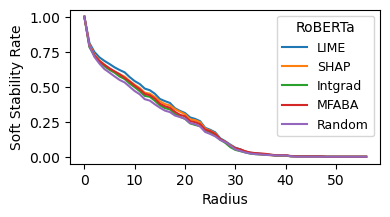

In [59]:
max_len = max(t.size(0) for t in lime_stability_rates)
all_radius = list(range(0, max_len))


plt.clf()
plt.figure(figsize=(4, 2))
plt.rcParams["font.family"] = "DejaVu Sans"

# plt.plot(all_radius, torch.nanmean(lime_stability_rates, dim=0), label="LIME")
# plt.plot(all_radius, torch.nanmean(intgrad_stability_rates, dim=0), label="IntGrad")
# plt.plot(all_radius, torch.nanmean(mfaba_stability_rates, dim=0), label="MFABA")

plt.plot(all_radius, torch.mean(torch.nan_to_num(lime_stability_rates, nan=0), dim=0)
, label="LIME")
plt.plot(all_radius, torch.mean(torch.nan_to_num(shap_stability_rates, nan=0), dim=0)
, label="SHAP")
plt.plot(all_radius, torch.mean(torch.nan_to_num(intgrad_stability_rates, nan=0), dim=0)
, label="Intgrad")
plt.plot(all_radius, torch.mean(torch.nan_to_num(mfaba_stability_rates, nan=0), dim=0)
, label="MFABA")
plt.plot(all_radius, torch.mean(torch.nan_to_num(random_stability_rates, nan=0), dim=0)
, label="Random")

plt.xlabel('Radius')
plt.ylabel('Soft Stability Rate')
plt.legend(title="RoBERTa", loc="upper right", prop={'size': 9})
# plt.title('Soft Stability')
plt.savefig('_dump/roberta_tweeteval_soft.pdf', bbox_inches="tight")
plt.show()


## As a comparison, here are the certified radii when old-MuS uses lambda=0.25

In [63]:
cert_mus_text = CertifiedMuSTextClassifier(raw_model, lambda_=0.25)

In [64]:
cert_lime_stability_rates = torch.cat([
    cert_mus_text(
        input_ids=text[0]['input_ids'].to(device), 
        attention_mask=text[0]['attention_mask'].to(device), 
        alpha=exp.to(device))["cert_rs"]
    for text, exp in tqdm(zip(data, lime_explanations), total=len(data))
], dim=0).cpu()

cert_shap_stability_rates = torch.cat([
    cert_mus_text(
        input_ids=text[0]['input_ids'].to(device), 
        attention_mask=text[0]['attention_mask'].to(device), 
        alpha=exp.to(device))["cert_rs"]
    for text, exp in tqdm(zip(data, shap_explanations), total=len(data))
], dim=0).cpu()

cert_intgrad_stability_rates = torch.cat([
    cert_mus_text(
        input_ids=text[0]['input_ids'].to(device), 
        attention_mask=text[0]['attention_mask'].to(device), 
        alpha=exp.to(device))["cert_rs"]
    for text, exp in tqdm(zip(data, intgrad_explanations), total=len(data))
], dim=0).cpu()

cert_mfaba_stability_rates = torch.cat([
    cert_mus_text(
        input_ids=text[0]['input_ids'].to(device), 
        attention_mask=text[0]['attention_mask'].to(device), 
        alpha=exp.to(device))["cert_rs"]
    for text, exp in tqdm(zip(data, mfaba_explanations), total=len(data))
], dim=0).cpu()

cert_random_stability_rates = torch.cat([
    cert_mus_text(
        input_ids=text[0]['input_ids'].to(device), 
        attention_mask=text[0]['attention_mask'].to(device), 
        alpha=exp.to(device))["cert_rs"]
    for text, exp in tqdm(zip(data, random_explanations), total=len(data))
], dim=0).cpu()

  0%|          | 0/374 [00:00<?, ?it/s]

In [35]:
torch.save(cert_lime_stability_rates, cache_dir / "roberta_lime_cert_stability_rates.pt")
torch.save(cert_shap_stability_rates, cache_dir / "roberta_shap_cert_stability_rates.pt")
torch.save(cert_intgrad_stability_rates, cache_dir / "roberta_intgrad_cert_stability_rates.pt")
torch.save(cert_mfaba_stability_rates, cache_dir / "roberta_mfaba_cert_stability_rates.pt")
torch.save(cert_mfaba_stability_rates, cache_dir / "roberta_random_cert_stability_rates.pt")

In [65]:
cert_lime_stability_rates = torch.load(prefix / cache_dir / "roberta_lime_cert_stability_rates.pt")
cert_shap_stability_rates = torch.load(prefix / cache_dir / "roberta_shap_cert_stability_rates.pt")
cert_intgrad_stability_rates = torch.load(prefix / cache_dir / "roberta_intgrad_cert_stability_rates.pt")
cert_mfaba_stability_rates = torch.load(prefix / cache_dir / "roberta_mfaba_cert_stability_rates.pt")
cert_random_stability_rates = torch.load(prefix / cache_dir / "roberta_random_cert_stability_rates.pt")

<Figure size 640x480 with 0 Axes>

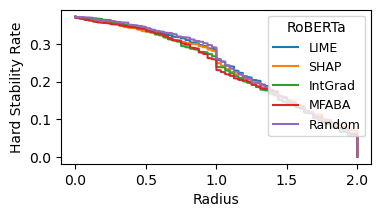

In [69]:
plt.clf()
plt.figure(figsize=(4, 2))
plt.rcParams["font.family"] = "DejaVu Sans"

plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="LIME")
plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="SHAP")
plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="IntGrad")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="MFABA")
plt.plot(cert_random_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="Random")
plt.xlabel('Radius')
plt.ylabel('Hard Stability Rate')
plt.legend(title="RoBERTa", loc="upper right", prop={'size': 9})
# plt.title('Hard Stability')
plt.savefig('_dump/roberta_tweeteval_hard.pdf', bbox_inches="tight")

## Combine soft and hard stability in the same plot

<Figure size 640x480 with 0 Axes>

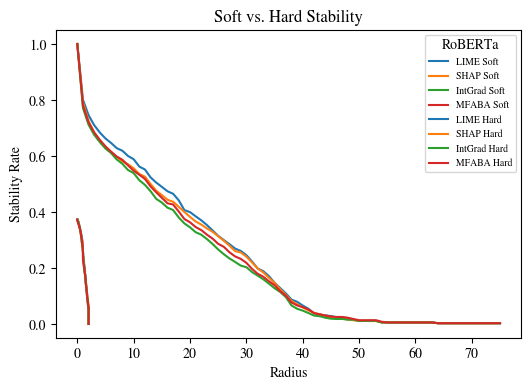

In [60]:
plt.clf()
plt.figure(figsize=(6, 4))
plt.plot(all_radius, torch.mean(torch.nan_to_num(lime_stability_rates, nan=0), dim=0)
, label="LIME Soft")
plt.plot(all_radius, torch.mean(torch.nan_to_num(shap_stability_rates, nan=0), dim=0)
, label="SHAP Soft")
plt.plot(all_radius, torch.mean(torch.nan_to_num(intgrad_stability_rates, nan=0), dim=0)
, label="IntGrad Soft")
plt.plot(all_radius, torch.mean(torch.nan_to_num(mfaba_stability_rates, nan=0), dim=0)
, label="MFABA Soft")

plt.plot(cert_lime_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="LIME Hard", color="#1f77b4")
plt.plot(cert_shap_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="SHAP Hard", color="#ff7f0e")
plt.plot(cert_intgrad_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="IntGrad Hard", color="#2ca02c")
plt.plot(cert_mfaba_stability_rates.sort(descending=True).values, [0.001 * i for i in range(0, len(data))], label="MFABA Hard", color="#d62728")
plt.xlabel('Radius')
plt.ylabel('Stability Rate')
plt.legend(title="RoBERTa", loc="upper right", prop={'size': 7})
plt.title('Soft vs. Hard Stability')
plt.savefig('_dump/roberta_tweeteval_softvhard', bbox_inches="tight")


## Visualization tool

In [ ]:

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

def show_attrs(tokens, masks, normalize=True):
    if normalize:
        masks_max = masks.max(-1).values
        masks_min = masks.min(-1).values
        # import pdb; pdb.set_trace()
        masks = (masks - masks_min) / (masks_max - masks_min)
    print_str = ""
    for i in range(len(tokens)):
        expln_val = masks[i].item()
        if expln_val == 0:
            print_str += f" {tokens[i]}"
        else:
            print_str += f"<span style='background-color:rgb({255 * (1-expln_val)},{255 * expln_val},{255 * expln_val})'> {tokens[i]}</span>"
    return print_str

tokens = data.tokenizer.convert_ids_to_tokens(input_ids[0])
# tokens = shap_expln.explainer_output.data[0]
printmd(show_attrs(tokens, expln.attributions[0]))